## Analyzing Stock Sentiment Data
<p>We'll be web scraping data from FinViz. Previously scraped data (HTML files) will be used at the start of the project and then functions will be created to perform the same analysis on live data. (We are doing this to avoid spamming FinViz).
    
The Approach:
<li>Import libraries, preprocess HTML data using Beautiful Soup</li>
<li>Structure data using Pandas, remove duplicates, instantiate NLTK's Sentiment Intensity Analyzer & calculate sentiment.
<li>Visualization: Various Plots showcasing sentiment scores. </li>
</ul>

## Initial Data Import
<li>Import libraries, preprocess HTML data using Beautiful Soup</li>

In [110]:
#Beautiful Soup
from bs4 import BeautifulSoup
import os
import re
#Structure Data
import pandas as pd
import numpy as np
#Sentiment & Graphing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [111]:
#Initial data load
html_tables = {}

for name in os.listdir('datasets'):
    table_path = 'datasets/{}'.format(name)
    with open(table_path, 'r') as file:
        soup = BeautifulSoup(file.read(), "html.parser")
        news = soup.find_all(id = 'news-table')
        html_tables[name] = news[0]

In [112]:
#Explore Data
tsla = html_tables['tsla_22sep.html']
#When we print tsla we can see headlines are marked with '<tr>' tags
tsla = tsla.find_all('tr')
for x in tsla:
    print(x)
    link_text = x.find('a')
    data_text = x.find_all('td')
    print('\n')
    print(link_text)
    print('\n')
    print(data_text)
    break

<tr><td align="right" style="white-space:nowrap" width="130">Sep-21-18 09:56PM  </td><td align="left"><a class="tab-link-news" href="https://finance.yahoo.com/video/billionaire-investor-questions-elon-musk-015608758.html" target="_blank">Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets</a> <span style="color:#aa6dc0;font-size:9px">Fox Business Videos</span></td></tr>


<a class="tab-link-news" href="https://finance.yahoo.com/video/billionaire-investor-questions-elon-musk-015608758.html" target="_blank">Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets</a>


[<td align="right" style="white-space:nowrap" width="130">Sep-21-18 09:56PM  </td>, <td align="left"><a class="tab-link-news" href="https://finance.yahoo.com/video/billionaire-investor-questions-elon-musk-015608758.html" target="_blank">Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets</a> <span style="color:#aa6dc0;font-size:9px">Fox Busin

In [113]:
#Parse Data
parsed = []

for key, table in html_tables.items():
    table = table.find_all('tr')
    ticker = key.split('_')[0]
    for x in table:
        values = x.find_all('td')
        date = values[0].get_text()
        headline = values[1].get_text()
        url = re.search(r"https(.)+ ", str(values[1]))
        try:
            url = url.group().split("\"")[0]
        except AttributeError:
            url = 'N/A'
        parsed.append([ticker, date, headline, url])

## Structure Data
<li>Convert to Pandas DataFrame, clean columns, remove duplicate headlines. Instantiate SentimentAnalyzer and calculate sentiment.</li></li>

In [421]:
#Convert parsed data into Pandas DataFrame
headline_df = pd.DataFrame(parsed, columns=['Ticker', 'Time', 'Headline', 'URL'])
headline_df.head()

,Ticker,Time,Headline,URL
0,fb,Jan-04-19 06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",https://www.thestreet.com/technology/faang-sto...
1,fb,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,https://finance.yahoo.com/news/earnings-calend...
2,fb,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,https://finance.yahoo.com/news/column-commenta...
3,fb,04:53PM,3 Tech Trends to Watch in 2019 Barrons.com,https://www.barrons.com/articles/technology-tr...
4,fb,04:30PM,Will Denver's tech growth continue in 2019? Am...,https://www.bizjournals.com/denver/news/2019/0...


In [422]:
#Grab date from time column
headline_df['Date'] = headline_df['Time'].str[:-9]

In [423]:
#Reorder columns
headline_df = headline_df[['Ticker', 'Date', 'Time', 'Headline', 'URL']]

In [424]:
#Add nan's for blanks to fill in NA's
headline_df.Date.replace('', np.nan, inplace=True)

In [425]:
#Fill forward as per FinViz.com's actual table build
headline_df['Date'].fillna(method='ffill', inplace=True)

In [426]:
#Remove date in time column now it has been extracted
headline_df['Time'] = headline_df['Time'].apply(lambda x : x[:] if len(x) < 10 else x[10:])

In [427]:
#Check shape
headline_df.shape

(500, 5)

In [428]:
#Check if there are duplicate headlines (even if a different news agency, verbatim headlines should be excluded)
headline_df.Headline.duplicated().sum()

21

In [429]:
#Drop duplicates
headline_df.drop_duplicates(subset=['Headline'], inplace=True)

In [430]:
#Confirm they were dropped
headline_df.Headline.duplicated().sum()

0

In [431]:
#Convert data & time columns to datetime
headline_df.Date = pd.to_datetime(headline_df.Date.str.strip())
headline_df.Time = pd.to_datetime(headline_df.Time.str.strip())

In [432]:
#Time to time
headline_df.Time = headline_df.Time.dt.time

In [434]:
#View cleaned dataset
headline_df.head()

,Ticker,Date,Time,Headline,URL
0,fb,2019-01-04,18:22:00,"Facebook, Apple, Netflix, Amazon and Alphabet ...",https://www.thestreet.com/technology/faang-sto...
1,fb,2019-01-04,17:15:00,Earnings Reports for the Week of Jan. 7-11 (BB...,https://finance.yahoo.com/news/earnings-calend...
2,fb,2019-01-04,16:55:00,COLUMN-Commentary: 2019 will be the year of mo...,https://finance.yahoo.com/news/column-commenta...
3,fb,2019-01-04,16:53:00,3 Tech Trends to Watch in 2019 Barrons.com,https://www.barrons.com/articles/technology-tr...
4,fb,2019-01-04,16:30:00,Will Denver's tech growth continue in 2019? Am...,https://www.bizjournals.com/denver/news/2019/0...


In [436]:
#Instantiate SIA object
SIA = SentimentIntensityAnalyzer()

#Some words that have positive connotation in stocks have negative meaning outside of them. Or are not in the lexicon
words = ['crushes', 'beats', 'misses', 'trouble', 'falls']

for word in words:
    try:
        print(word, SIA.lexicon[word])
    except KeyError:
        pass

crushes -1.9
misses -0.9
trouble -1.7


In [437]:
#Update lexicon with new scores
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

SIA.lexicon.update(new_words)

In [438]:
#Calculate Sentiment
scores = [SIA.polarity_scores(x) for x in headline_df.Headline]
scores_df = pd.DataFrame(scores)

In [439]:
#Reset index to ensure clean join
headline_df = headline_df.reset_index(drop=True)

In [440]:
df = headline_df.join(scores_df)

In [441]:
df

,Ticker,Date,Time,Headline,URL,neg,neu,pos,compound
0,fb,2019-01-04,18:22:00,"Facebook, Apple, Netflix, Amazon and Alphabet ...",https://www.thestreet.com/technology/faang-sto...,0.000,0.661,0.339,0.4767
1,fb,2019-01-04,17:15:00,Earnings Reports for the Week of Jan. 7-11 (BB...,https://finance.yahoo.com/news/earnings-calend...,0.000,1.000,0.000,0.0000
2,fb,2019-01-04,16:55:00,COLUMN-Commentary: 2019 will be the year of mo...,https://finance.yahoo.com/news/column-commenta...,0.000,1.000,0.000,0.0000
3,fb,2019-01-04,16:53:00,3 Tech Trends to Watch in 2019 Barrons.com,https://www.barrons.com/articles/technology-tr...,0.000,1.000,0.000,0.0000
4,fb,2019-01-04,16:30:00,Will Denver's tech growth continue in 2019? Am...,https://www.bizjournals.com/denver/news/2019/0...,0.000,0.794,0.206,0.3818
...,...,...,...,...,...,...,...,...,...
474,tsla,2018-11-16,08:31:00,VW says could build up to 15 million electric ...,https://finance.yahoo.com/news/vw-says-could-b...,0.000,1.000,0.000,0.0000
475,tsla,2018-11-16,08:12:00,Elon Musk to Prowl Production Lines in Push fo...,https://finance.yahoo.com/news/elon-musk-prowl...,0.000,1.000,0.000,0.0000
476,tsla,2018-11-16,06:39:00,Tesla cuts prices on solar power systems as it...,https://finance.yahoo.com/news/tesla-cuts-pric...,0.145,0.855,0.000,-0.2960
477,tsla,2018-11-16,06:00:00,Tesla StretchÂ Pushes Customers to Open Wallet...,https://finance.yahoo.com/news/tesla-stretch-p...,0.000,1.000,0.000,0.0000


## Visualization
<li>Various Plots showcasing sentiment scores.</li>

In [442]:
#Plot mean sentiment by stock, date

grouped = df.groupby(['Date', 'Ticker']).mean()
grouped = grouped.unstack('Ticker')
grouped.head()

neg                 neu                 pos            \
Ticker            fb      tsla        fb      tsla        fb      tsla   
Date                                                                     
2018-09-18  0.111150  0.101750  0.837000  0.830000  0.051850  0.068250   
2018-09-19  0.063682  0.069634  0.821227  0.880854  0.115045  0.049512   
2018-09-20  0.046414  0.069000  0.897448  0.777696  0.056138  0.153304   
2018-09-21  0.068762  0.092300  0.876810  0.835200  0.054429  0.072500   
2018-09-22  0.000000       NaN  0.904500       NaN  0.095500       NaN   

            compound            
Ticker            fb      tsla  
Date                            
2018-09-18 -0.079840 -0.085650  
2018-09-19  0.062255 -0.038478  
2018-09-20  0.013803  0.129309  
2018-09-21 -0.029229 -0.049575  
2018-09-22  0.255300       NaN

<AxesSubplot:xlabel='Date'>

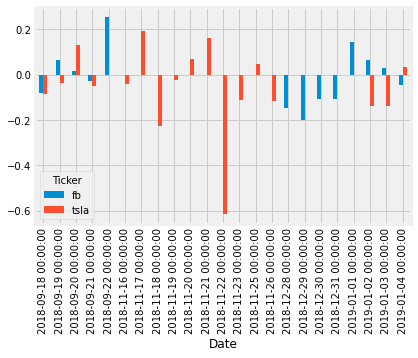

In [443]:
plt.style.use("fivethirtyeight")
%matplotlib inline

grouped['compound'].plot.bar()

In [444]:
#What happened on nov 22nd to Tesla

df_filtered = df[(df['Date'] == 'Nov-22-18') & (df['Ticker'] == 'tsla')]
df_filtered

,Ticker,Date,Time,Headline,URL,neg,neu,pos,compound
408,tsla,2018-11-22,08:23:00,Tesla Cuts China Car Prices: Can Others Surviv...,https://finance.yahoo.com/news/tesla-cuts-chin...,0.180,0.820,0.0,-0.2960
409,tsla,2018-11-22,03:55:00,[$$] Tesla cuts prices in China as trade war b...,N/A,0.379,0.621,0.0,-0.7269
410,tsla,2018-11-22,01:24:00,Tesla Lowers Car Prices in China After Trade W...,https://finance.yahoo.com/news/tesla-lowers-ca...,0.434,0.566,0.0,-0.7096
411,tsla,2018-11-22,01:02:00,Tesla cuts China car prices to absorb hit from...,https://finance.yahoo.com/news/tesla-says-cuts...,0.357,0.643,0.0,-0.7269


In [445]:
#Since these are not exact duplicates we will keep them. (Same publisher but different headline and article around same topic)

In [609]:
#Sentiment on the same day, same stock
#Facebook Jan-03-19
single_day = df.set_index(['Ticker', 'Date'])
single_day = single_day.loc['fb']
single_day = single_day.loc['Jan-03-19']
single_day.sort_values(by='Time', inplace=True)
single_day.head()

,Time,Headline,URL,neg,neu,pos,compound
Date,,,,,,,
2019-01-03,06:00:00,Why Internet Censorship Doesnt Work and Never ...,https://finance.yahoo.com/news/why-internet-ce...,0.000,1.000,0.000,0.0000
2019-01-03,08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Fa...",https://finance.yahoo.com/news/3-big-stock-cha...,0.000,1.000,0.000,0.0000
2019-01-03,09:07:00,"The Zacks Analyst Blog Highlights: Facebook, W...",https://finance.yahoo.com/news/zacks-analyst-b...,0.000,0.857,0.143,0.2500
2019-01-03,09:12:00,Why The FAANGs Are Crucial To A 2019 Market Ra...,https://www.investopedia.com/why-the-faangs-ar...,0.000,1.000,0.000,0.0000
2019-01-03,09:34:00,Apple warning stoking fears of slowdown in Chi...,https://finance.yahoo.com/video/apple-warning-...,0.366,0.634,0.000,-0.6369


In [610]:
#Build x and y's for stacked bar graph
x = single_day.Time.astype(str)
y_pos = single_day.pos
y_neg = single_day.neg
y_neu = single_day.neu

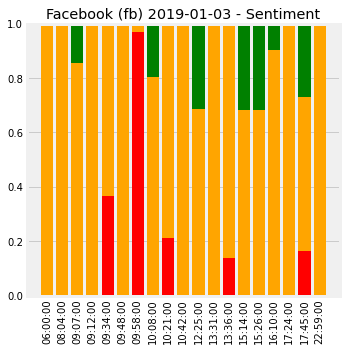

In [612]:
#Build stacked bar plot and show it
plt.figure(figsize=(5, 5))
plt.xticks(rotation=90)
plt.title('Facebook (fb) 2019-01-03 - Sentiment')
plt.bar(x, y_neg, label='Negative', color='red')
plt.bar(x, y_neu, bottom=y_neg, label='Neutral', color='Orange')
plt.bar(x, y_pos, bottom=y_neg+y_neu, color='green')
plt.show()